# Assignment 2, Exercise 1, Classification

## Export Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Implementations

In [45]:
def read_infections_data():
    """Read in the csv data into a dataframe and perform the correct conversion of associated categorical values, and their data-types as well."""
    infections_data = pd.read_csv("Pneumonia Infections.csv")
    infections_data.columns = [c.replace(' ', '_') for c in infections_data.columns]
    
    # gender mapping
    infections_data['Gender'] = infections_data['Gender'].map({'Other': 0, 'Female': 1, 'Male': 2})
    infections_data['Gender'] = pd.to_numeric(infections_data['Gender'])
    
    # smoker mapping
    infections_data['Smoker'] = infections_data['Smoker'].map({'No': 0, 'Yes': 1})
    infections_data['Smoker'] = pd.to_numeric(infections_data['Smoker'])

    # pnumonia_diagnosed mapping
    infections_data['Pneumonia_diagnosed'] = infections_data['Pneumonia_diagnosed'].map({'No': 0, 'Yes': 1})
    infections_data['Pneumonia_diagnosed'] = pd.to_numeric(infections_data['Pneumonia_diagnosed'])

    return infections_data

In [46]:
def remove_erronous_observations(infections_data):
    """Write a function that excludes erronous observations."""
    infections_data_cleaned = infections_data.dropna().reset_index(drop=True)
    return infections_data_cleaned

In [47]:
def remove_redundant_features(infections_data, corr_threshold=0.8):
    """Write a function that excludes redundant input features that have no effect or are highly correlated with other feautres."""
    
    # remove identifer
    infections_data = infections_data.drop(columns=['Paitent_#'])
    
    corr_matrix = infections_data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    infections_data = infections_data.drop(columns=to_drop)
    
    # plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()
    
    return infections_data

In [48]:
def standardize_and_categorize_features(infections_data):
    """Write a function that standardizes numerical features and performs one-hot encoding on categorical features"""
    
    cat_cols = infections_data.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = infections_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Pneumonia_diagnosed']).columns.tolist()

    # for numerical columns
    scaler = StandardScaler()
    infections_data[num_cols] = scaler.fit_transform(infections_data[num_cols])

    # for categorical features
    infections_data = pd.get_dummies(infections_data, columns=cat_cols, drop_first=True)
    
    return infections_data

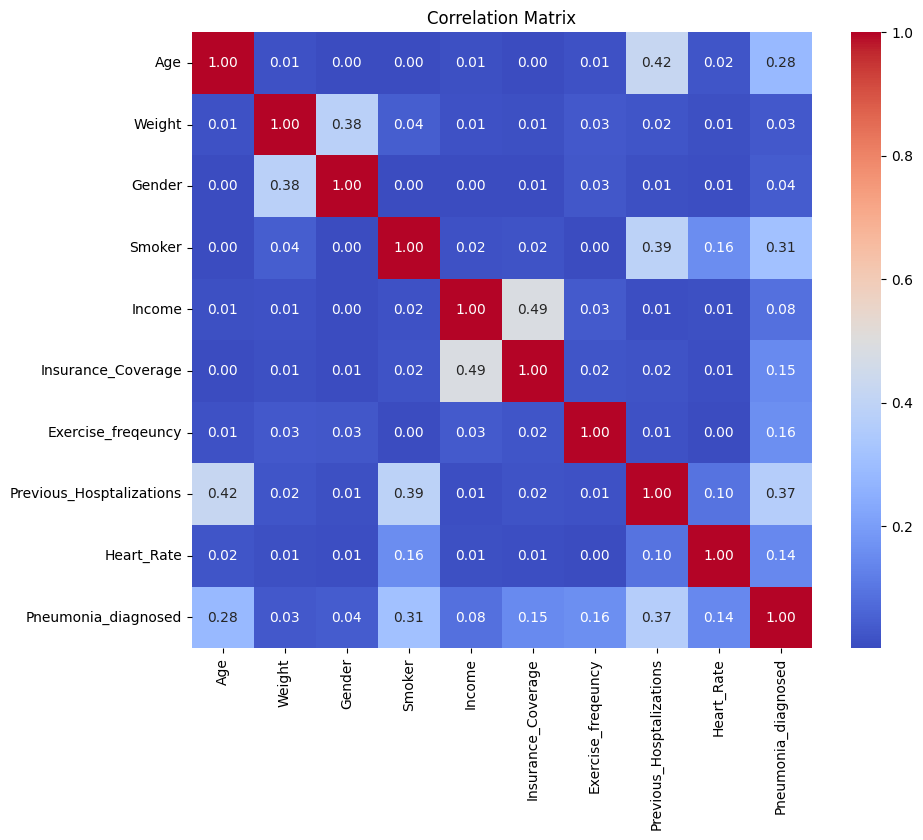

,Age,Weight,Gender,Smoker,Income,Insurance_Coverage,Exercise_freqeuncy,Previous_Hosptalizations,Heart_Rate,Pneumonia_diagnosed
0,0.668324,0.195164,-0.592644,2.026809,1.244912,0.789046,-1.383068,0.174535,0.877208,0.0
1,0.668324,0.739934,-0.592644,-0.493386,-1.467703,-0.187471,1.425768,-1.063116,-1.132026,0.0
2,-0.456665,0.794411,-0.592644,-0.493386,-1.375750,-1.338868,-1.383068,-0.238016,-0.782594,0.0
3,-1.640865,-1.766010,-0.592644,-0.493386,1.474795,-1.301849,0.723559,-0.650566,-1.132026,0.0
4,1.674893,-0.404083,-0.592644,-0.493386,-0.272313,0.362697,-1.383068,1.412185,0.702492,0.0
...,...,...,...,...,...,...,...,...,...,...
2692,-1.522445,-0.839900,0.972842,-0.493386,0.141475,0.519706,-1.383068,-1.063116,0.789850,0.0
2693,-0.871135,-0.349606,-0.592644,2.026809,1.336865,0.833723,1.425768,-1.063116,1.750788,1.0
2694,-1.344815,0.630980,0.972842,-0.493386,-1.605633,-1.133352,-0.680859,-1.063116,-0.258446,0.0
2695,0.786744,-1.874964,-2.158130,-0.493386,1.015030,-0.445323,1.425768,-0.238016,-0.607878,1.0


In [49]:
# TEST FOR METHODS SO FAR, DELETE LATER

df = read_infections_data()
df = remove_erronous_observations(df)
df = remove_redundant_features(df)
df = standardize_and_categorize_features(df)

df

In [50]:
def split_train_test(...):
    "Write a function that splits data between train and test in a ration of 75-25%."
    return...

SyntaxError: invalid syntax (942995698.py, line 1)

In [ ]:
def train_LR(...):
    "Write a function that trains a Logistic Regression where 2 hyperparameters are selected using Gridsearch Cross validation."
    return...

In [ ]:
def train_DT(...):
    "Write a function that trains a Decision Tree where 2 hyperparameters are selected using Gridsearch Cross validation."
    return...

In [ ]:
def train_LR_best_params(...):
    "Write a function that trains a Logistic Regression with the best hyper-parameters."
    return...

In [ ]:
def train_DT_best_params(...):
    "Write a function that trains a Decision Tree with the best hyper-parameters."
    return...

In [ ]:
def predict_evaluate(...):
    "Write a function that evalutes both algorithms using statisitcs on their predictions pretaining to precision, recall and accuracy alongside producing the confusion matrix"
    return...

# Assignment 2, Exercise 2, K-means Clustrering


## Export Libraries

## Implementations

In [ ]:
# *** Write your code here to do statistical analysis***

In [ ]:
# *** Write your code here to normalize the data and transform it to a number array***

In [ ]:
# *** Insert your code here to analyze the number of clusters using inertia***

In [ ]:
# *** Insert your code here to analyze the number of clusters using Silhouette score***